# Modeling S&P 500 Forecasts
Train and evaluate models using engineered features.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools, warnings



In [63]:
# Load data with features
df = pd.read_csv("features.csv", parse_dates=["Date"], index_col="Date")

# Adiciona lags e novas features
df['return_lag1'] = df['return'].shift(1)
df['return_lag2'] = df['return'].shift(2)
df['close_lag1'] = df['Close'].shift(1)
df['close_lag2'] = df['Close'].shift(2)
df['ma_diff'] = df['ma7'] - df['ma21']

# Tratar valores NaN (preencher com o valor anterior e seguinte)
df = df.fillna(method='ffill').fillna(method='bfill')



/tmp/ipykernel_1868/3541473338.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [64]:
# Seleciona features relevantes
features = [
    'Open', 'High', 'Low', 'Close', 'Adj Close',
    'return', 'ma7', 'ma21', 'volatility_7',
    'return_lag1', 'return_lag2', 'close_lag1', 'close_lag2', 'ma_diff'
]

# Normalizar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
X = pd.DataFrame(X_scaled, index=df.index, columns=features)
y = df['target']

# Separar treino e teste mantendo ordem temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)



In [65]:
# Treinar modelo SARIMAX (SARIMA com exógenas)


# Usamos X_train/X_test como exógenas. Você pode remover exog se quiser um modelo puramente univariado.
# Parâmetros iniciais: order e seasonal_order são pontos de partida — faça busca/validação para otimizar.
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 5)  # sazonalidade semanal (5 dias); ajuste para 252 se preferir anual

# Garante que exógenas são arrays/numpy com índices alinhados
exog_train = X_train.values
exog_test = X_test.values

model = SARIMAX(y_train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast para o período de teste
y_pred = model_fit.forecast(steps=len(y_test), exog=exog_test)
# Converter para Series com mesmo índice de y_test para facilitar avaliação/plot
y_pred = pd.Series(list(y_pred), index=y_test.index)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)



/home/turo/ML-Stock-Market/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/turo/ML-Stock-Market/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/turo/ML-Stock-Market/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/turo/ML-Stock-Market/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

In [ ]:

warnings.filterwarnings("ignore")

def rolling_cv_rmse(y, exog, order, seasonal, horizon=5, init_frac=0.6, maxiter=60):
    n = len(y)
    start = int(n * init_frac)
    rmses = []
    while start + horizon <= n:
        y_tr = y.iloc[:start]
        y_te = y.iloc[start:start+horizon]
        x_tr = exog.iloc[:start] if exog is not None else None
        x_te = exog.iloc[start:start+horizon] if exog is not None else None
        try:
            m = SARIMAX(y_tr, exog=None if x_tr is None else x_tr.values,
                        order=order, seasonal_order=seasonal,
                        enforce_stationarity=False, enforce_invertibility=False)
            f = m.fit(disp=False, maxiter=maxiter)
            pred = f.forecast(steps=horizon, exog=None if x_te is None else x_te.values)
            rmses.append(np.sqrt(mean_squared_error(y_te, pred)))
        except Exception:
            rmses.append(np.inf)
        start += horizon
    return np.mean(rmses) if rmses else np.inf

def tune_sarimax(y, exog, p=(0,1,2), d=(0,1), q=(0,1,2),
                 P=(0,1), D=(0,1), Q=(0,1), season_list=(5,21,252),
                 horizon=5):
    best = {"rmse": np.inf}
    for s in season_list:
        for (p_, d_, q_, P_, D_, Q_) in itertools.product(p,d,q,P,D,Q):
            order = (p_, d_, q_)
            seasonal = (P_, D_, Q_, s)
            rmse = rolling_cv_rmse(y, exog, order, seasonal, horizon=horizon)
            print(f"order={order} seasonal={seasonal} rmse={rmse:.4f}")
            if rmse < best["rmse"]:
                best = {"rmse": rmse, "order": order, "seasonal_order": seasonal}
    return best

# Tuning no conjunto de treino (sem vazamento)
best = tune_sarimax(y_train, X_train, p=(0,1,2,3), d=(0,1), q=(0,1,2,3),
                    P=(0,1), D=(0,1), Q=(0,1), season_list=(5,21), horizon=5)
print("Best:", best)

# Refit final e previsão no teste
model = SARIMAX(y_train, exog=X_train.values,
                order=best["order"], seasonal_order=best["seasonal_order"],
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False, maxiter=100)

y_pred = pd.Series(model_fit.forecast(steps=len(y_test), exog=X_test.values), index=y_test.index)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


RMSE: 1072.75
R² Score: -1.7087


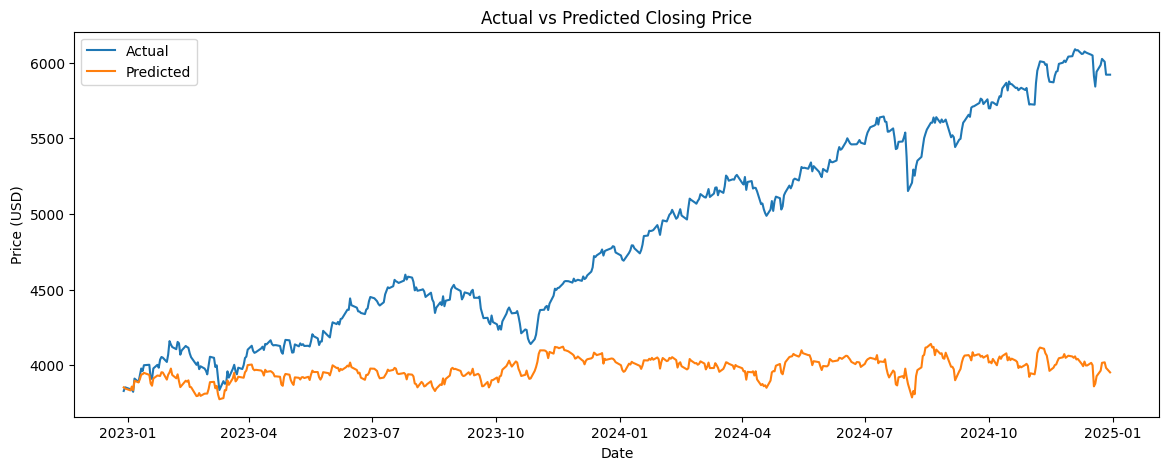

In [ ]:
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# # Importância das features
# importances = model.feature_importances_
# feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
# plt.figure(figsize=(10,4))
# sns.barplot(x=feature_importance.values, y=feature_importance.index)
# plt.title("Feature Importance")
# plt.show()

# Visualização das previsões
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Actual vs Predicted Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()